In [1]:
import tensorflow as tf
import numpy as np
import os

In [2]:
DATASET_PATH = "./Dataset/Logos/"
INP_SIZE = (100, 100)

images = []

In [3]:
for filename in os.listdir(DATASET_PATH):
    img = tf.keras.utils.load_img(os.path.join(DATASET_PATH, filename), target_size = INP_SIZE)
    img = tf.keras.utils.img_to_array(img)
    images.append(img)

In [4]:
images = np.asarray(images).astype(np.float32) / 255

In [5]:
x_train = images[:-10]
x_test = images[-10:]

In [6]:
BATCH_SIZE = 5
EPOCHS = 25
LEARNING_RATE = 1e-4

IMG_ORIGINAL_SIZE = x_train[0].shape
IMG_SIZE = IMG_ORIGINAL_SIZE[0]*IMG_ORIGINAL_SIZE[1]*IMG_ORIGINAL_SIZE[2]

HIDDEN_DIM = 128
LATENT_DIM = 16

In [7]:
class VAE(tf.keras.Model):
    def __init__(self, dim, **kwargs):
        super(VAE, self).__init__(**kwargs)
        
        h_dim = dim[0]
        z_dim = dim[1]
        
        self.fc1 = tf.keras.layers.Dense(h_dim, activation = tf.nn.relu)
        self.fc2 = tf.keras.layers.Dense(z_dim)
        self.fc3 = tf.keras.layers.Dense(z_dim)
        
        self.fc4 = tf.keras.layers.Dense(h_dim)
        self.fc5 = tf.keras.layers.Dense(IMG_SIZE)
        
        self.encode_batch_norm = tf.keras.layers.BatchNormalization()
        self.decode_batch_norm = tf.keras.layers.BatchNormalization()
        
    def encode(self, input):
        x = self.encode_batch_norm(input)
        h = self.fc1(x)
        return self.fc2(h), self.fc3(h)
    
    def decode_logits(self, x):
        h = self.fc4(x)
        h = self.fc5(h)
        return self.decode_batch_norm(h)
    
    def decode(self, x):
        return tf.nn.sigmoid(self.decode_logits(x))
    
    def reparameterize(self, mu, sigma):
        std = tf.exp(sigma * 0.5)
        eps = tf.random.normal(std.shape)
        return mu + eps*std
    
    def call(self, input):
        mu, sigma = self.encode(input)
        z = self.reparameterize(mu, sigma)
        logits = self.decode_logits(z)
        
        return logits, mu, sigma

In [8]:
model = VAE([HIDDEN_DIM, LATENT_DIM])
model.build(input_shape = (BATCH_SIZE, IMG_SIZE))
model.summary()

d:\Apps\Conda\envs\TensorFlow\Lib\site-packages\keras\src\layers\layer.py:391: UserWarning: `build()` was called on layer 'vae', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "vae"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ ?                      │   0 (unbuilt) │
│ (BatchNormalization)            │                        │               │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 0 (0.00 B)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 0 (0.00 B)

In [9]:
dataset = tf.data.Dataset.from_tensor_slices(x_train)
dataset = dataset.shuffle(BATCH_SIZE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

optimizer = tf.keras.optimizers.Adam(learning_rate = LEARNING_RATE)

In [11]:
loss_hist = []
kl_div_hist = []

for e in range(EPOCHS):
    for x in dataset:
        x = tf.reshape(x, [-1, IMG_SIZE])
        with tf.GradientTape() as tape:
            logits, mu, sigma = model(x)
            
            recon_loss = tf.nn.sigmoid_cross_entropy_with_logits(x, logits)
            recon_loss = tf.reduce_sum(recon_loss) / BATCH_SIZE
            
            kl_div = -0.5 * tf.reduce_sum(1.0 + sigma - tf.square(mu) - tf.exp(sigma), axis=1)
            kl_div = tf.reduce_mean(kl_div)
            
            loss = tf.reduce_mean(kl_div + recon_loss)
            
        gradient = tape.gradient(loss, model.trainable_variables)
        optimizer.apply_gradients(zip(gradient, model.trainable_variables))
        
        loss_hist.append(loss)
        kl_div_hist.append(kl_div)
        
    print(f"Epoch #{e+1} | Loss = {recon_loss} | kl_div = {kl_div} | loss = {loss}")

Epoch #1 | Loss = 8746.494140625 | kl_div = 507.01348876953125 | loss = 9253.5078125
Epoch #2 | Loss = 3826.444580078125 | kl_div = 528.7061767578125 | loss = 4355.15087890625
Epoch #3 | Loss = 3818.872314453125 | kl_div = 495.6114807128906 | loss = 4314.48388671875
Epoch #4 | Loss = 3385.748046875 | kl_div = 420.10992431640625 | loss = 3805.85791015625
Epoch #5 | Loss = 5272.490234375 | kl_div = 381.5404968261719 | loss = 5654.03076171875
Epoch #6 | Loss = 3236.49267578125 | kl_div = 361.78546142578125 | loss = 3598.278076171875
Epoch #7 | Loss = 3144.88232421875 | kl_div = 401.7567443847656 | loss = 3546.63916015625
Epoch #8 | Loss = 3049.0390625 | kl_div = 364.1871032714844 | loss = 3413.22607421875
Epoch #9 | Loss = 5611.78369140625 | kl_div = 255.07177734375 | loss = 5866.85546875
Epoch #10 | Loss = 6200.9267578125 | kl_div = 256.6893005371094 | loss = 6457.6162109375
Epoch #11 | Loss = 3742.844482421875 | kl_div = 258.62884521484375 | loss = 4001.473388671875
Epoch #12 | Loss = 3

In [12]:
import matplotlib.pyplot as plt

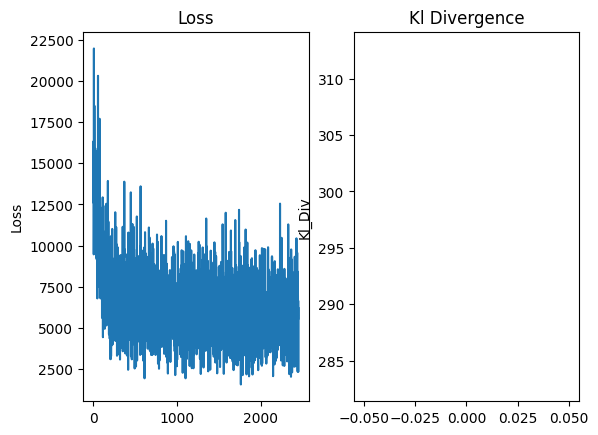

In [15]:
plt.subplot(1, 2, 1)
plt.plot(loss_hist)
plt.title("Loss")
plt.ylabel("Epochs")
plt.ylabel("Loss")

plt.subplot(1, 2, 2)
plt.plot(kl_div)
plt.title("Kl Divergence")
plt.ylabel("Epochs")
plt.ylabel("Kl_Div")

plt.show()

In [ ]:
def get_img(z):
    out = model.decode(z)
    out = tf.reshape(out, [-1] + list(IMG_ORIGINAL_SIZE))
    return out

In [ ]:
mu, sigma = model.encode(x_test.reshape(-1, IMG_SIZE))
z = model.reparameterize(mu, sigma)
recon_img = get_img(z)

In [ ]:
fig, ax = plt.subplot(nrows = 2, ncols = len(x_test))
for i in len(x_test):
    ax[0, i].imshow(x_test[i])
    ax[0, i].get_xaxis().set_visible(False)
    ax[0, i].get_yaxis().set_visible(False)
    
    ax[1, i].imshow(recon_img[i])
    ax[1, i].get_xaxis().set_visible(False)
    ax[1, i].get_yaxis().set_visible(False)
    
plt.show()